# Описание проекта. 

В рамках проекта была разработана рекомендательная система, позволяющая определять товар из ассортимента магазина по набору характеристик.

**Исходные данные:**
- Набор данных товара магазина с набором зашифрованных признаков.
- Набор данных с признаками, в которых товар не определен.

**Задача:**

Построить рекомендательную систему, которая сможет определить 5 товаров наиболее подходящих к заправшиваемым признакам. Для определения качествва рекомендательной модели использовать метрику accuracy@5.

**Используемые инструменты:**
- FAISS;
- CatBoost;
- Pandas;
- Numpy.


![](https://raw.githubusercontent.com/htoniy/Data-Science_Classic-ML/main/01_Product%20matching/images/Code%20algoritm.png)

**Используемая литература:**
- FAISS
    - https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/
    - https://habr.com/ru/companies/okkamgroup/articles/509204/
    - https://evogeek.ru/articles/298310/
    - https://www.pinecone.io/learn/series/faiss/faiss-tutorial/
    - https://towardsdatascience.com/understanding-faiss-619bb6db2d1a
    - https://towardsdatascience.com/getting-started-with-faiss-93e19e887a0c


#  Импорт данных.

Импорт библиотек.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math

#conda install -c conda-forge faiss
import faiss

# pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

import random
from random import random, randrange, randint

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import PowerTransformer

#ML
from sklearn.model_selection import train_test_split 
#pip install catboost
from catboost import CatBoostClassifier

Импорт исходных данных.

In [2]:
base = pd.read_csv('./data/base.csv', index_col=0)
train = pd.read_csv('./data/train.csv', index_col=0)
validation = pd.read_csv('./data/validation.csv')
validation_answer = pd.read_csv('./data/validation_answer.csv')


**Описание данных.**
- **base.csv** - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- **train.csv -** обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- **validation.csv** - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- **validation_answer.csv** - правильные ответы к предыдущему файлу.


# Построение Baseline.

**Анализ на пропуски.**

In [3]:
data = [base, train, validation, validation_answer]
print('Наличие пропусков в датафрейме - 1.')
print('Отсутствие пропусков в датафрейме - 0.')
print('_____________________________________')
for i in range(len(data)):
    x=data[i].isna().sum().unique()
    name=['base', 'train', 'validation', 'validation_answer']
    name = name[i]
    print(f'Наличие пропусков данных в датафрейме {name}: {x}')

Наличие пропусков в датафрейме - 1.
Отсутствие пропусков в датафрейме - 0.
_____________________________________
Наличие пропусков данных в датафрейме base: [0]
Наличие пропусков данных в датафрейме train: [0]
Наличие пропусков данных в датафрейме validation: [0]
Наличие пропусков данных в датафрейме validation_answer: [0]


**Пропуски в наборах данных отсутствуют.**

## Create index for base.

In [4]:
dims = base.shape[1]
n_cells = 500
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

**Примечания:**

**dims** - Размерность пространства, кол-о признаков. (dimensions of each vector)

**n_cells** - кол-во кластеров, которые должны быть сформированы.

**quantizer** - квантователь. Необходим для присвоения векторов определенному кластеру. Обычно это еще один индекс, который использует метрику расстояния L2 (мы используем индекс FlatL2).

Для всех векторовв применяется индексный тип IndexIVFFlat. «Плоский» здесь означает, что векторы хранятся как есть, без какого-либо сжатия или квантования.

Обучение индекса для создания «nlist» числа кластеров. Добавление ввекторов к этим кластерам. 

In [5]:
%%time
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))

CPU times: user 16.9 s, sys: 1.95 s, total: 18.8 s
Wall time: 7.76 s


Словарь для приввязки ID товара к номерам векторов. Т.к. в обученном индексе сохранены только параметры без учета индексации, используем этот словарь в дальнейшем при работе с base.

In [6]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}
print('Пример позиции словаря:', base_index[3])

Пример позиции словаря: 3-base


## Train

Определение целевого признака и набора фичей.

In [7]:
target_train = train["Target"]
features_train = train.drop("Target", axis=1)

Метод **idx_l2.search** определяет для каждой заданной 1 позиции 5 ближайших соседей.

In [8]:
%%time
vecs, idx = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), 5)

CPU times: user 57.9 s, sys: 442 ms, total: 58.3 s
Wall time: 8.41 s


In [9]:
acc = 0
for i, el in zip(target_train.values.tolist(), idx.tolist()):
    acc += int(i in [base_index[r] for r in el])

print(100 * acc / len(idx))

5.133


In [10]:
#Creation of a DataFrame to compare all model changes and control all modifications.
data = {'change description':[],
        'accuracy@5':[],
        'time':[]
       }
experiment = pd.DataFrame(data)

In [11]:
new_result = {'change description':'Base line model',
        'accuracy@5':5.133,
        'time':'8.47 s'
       }

In [12]:
experiment = experiment.append(new_result, ignore_index=True)
experiment

,change description,accuracy@5,time
0,Base line model,5.133,8.47 s


## Вывод.

На сырых данных базавая модель показала метрику 5.133. 

#  Предобработка данных.

## Анализ распределения данных в признаках.

**Построение графиков распределения значений параметров.**

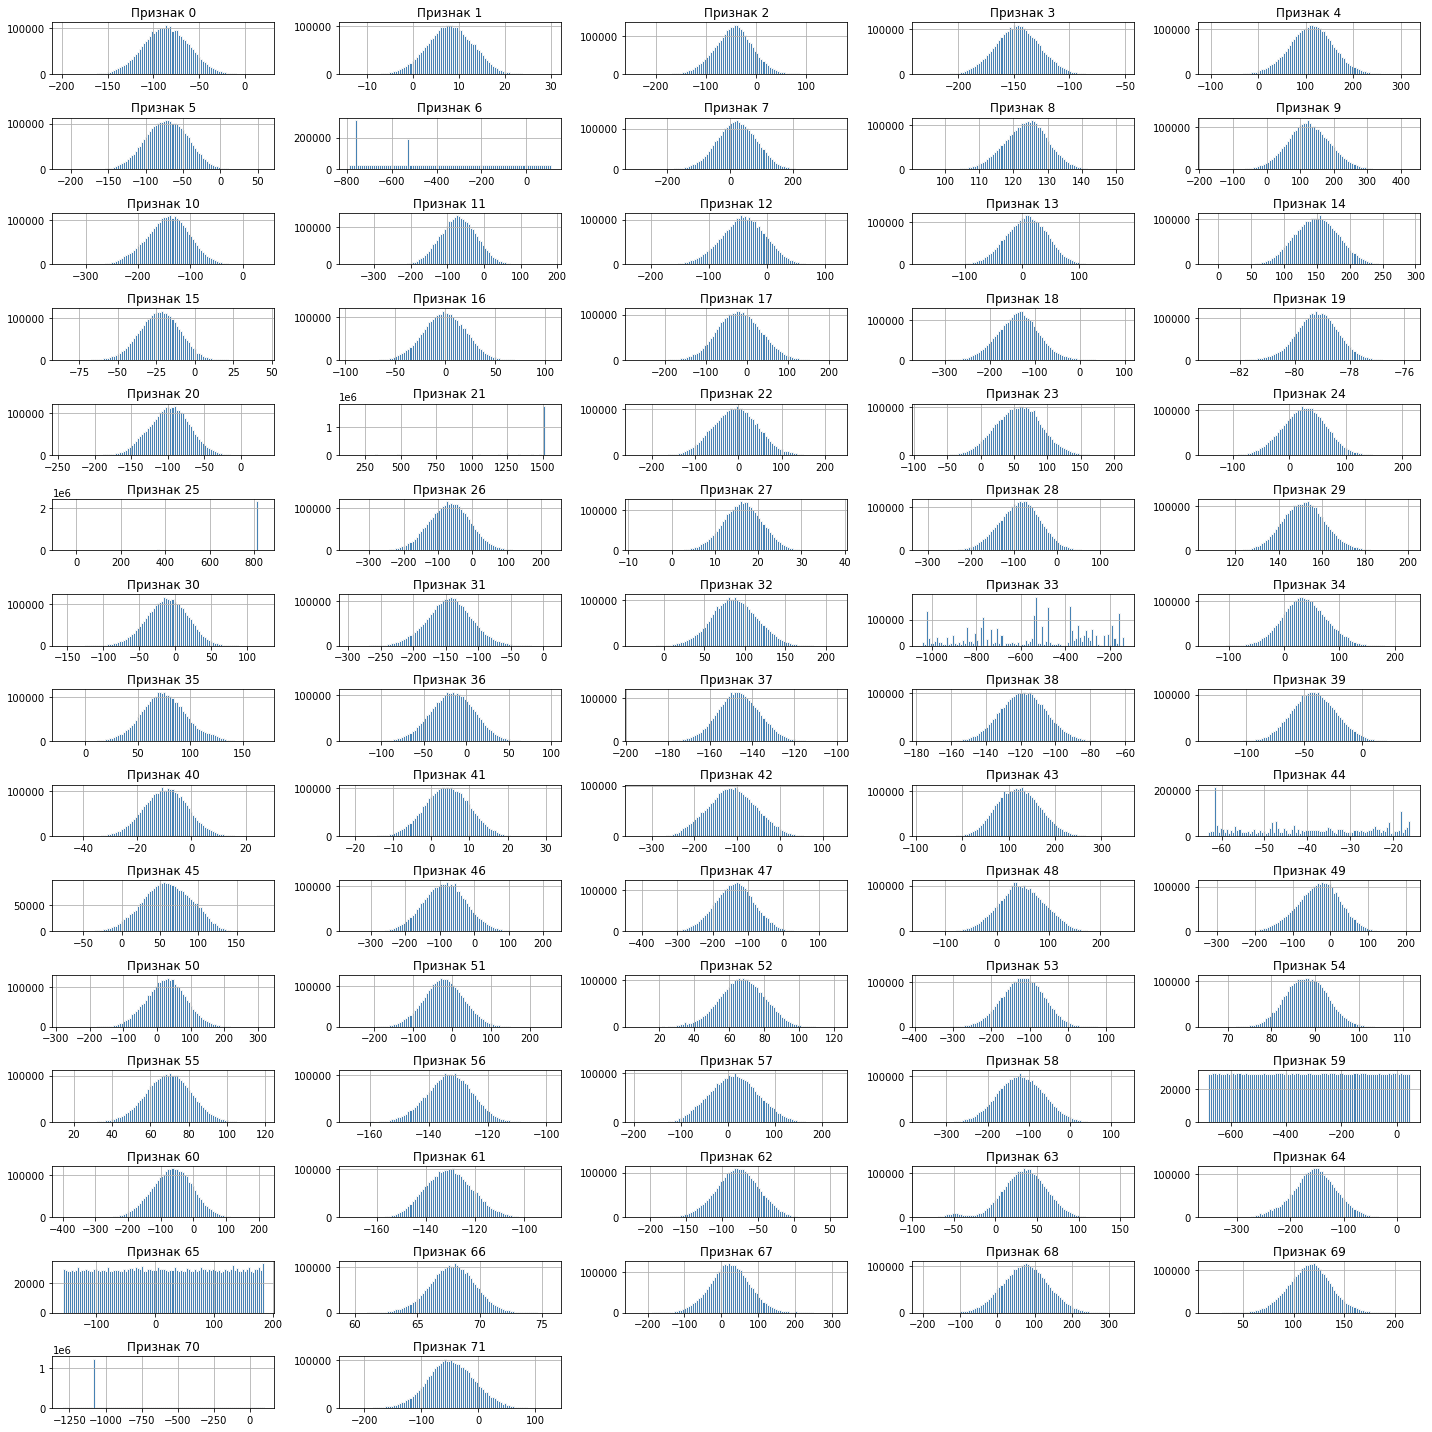

In [13]:
num_columns = base.shape[1] #Get the columns quantity
num_rows = 15 #Rows number in subplot grid
num_cols = 5 #Columns number in subplot grid
fig, axis = plt.subplots(num_rows, num_cols, figsize =(20, 20))

for i, ax in enumerate(axis.flat):
    if i < num_columns:
        base.iloc[:, i].hist(
                bins=100,
                color = 'steelblue',
                edgecolor='whitesmoke',
                linewidth = 1,
                ax=ax
                )
        ax.set_title(f'Признак {i}')

    else:
        ax.axis('off')
    
plt.tight_layout()
plt.show()

**Описание графиков распределений значений для каждого признака:**

По распределению значений признаки можно распределить на 3 категории:

1) Признаки распределены по нормальному закону.

2) В признаке преобладает один небольшой диапазон значений, на фоне которого, остальные значения кажутся незначительными. К таким признакам относятся следующие переменные: ['6', '21', '25', '33', '44', '70'].

3) Значения признаков распределены равномерно в следующих фичах: [59, 65]

Из анализа распределения значений видно, что признаки имеют расзные диапозоны и порядки значений. Т.к. библиотека FAISS работает с Евклидовывм расстоянием, то разный порядок значений параметров может приести к искажению результатов модели. Для предотвращения потери качества метрики необходимо проивести стандартизацию данных.

## Стандартизация признаков.

Стандартизация числоваых признаков на базе библиотеки **Sklearn**.

In [14]:
scaler = StandardScaler()

# Замена 'df' на  DataFrame и определение списка числовых признаков.
numerical_features = base.columns

# Примение стандартизации к числовым признакам.
base[numerical_features] = scaler.fit_transform(base[numerical_features])

In [15]:
base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,-0.282884,0.373663,-0.435627,0.884544,...,1.189049,0.190524,0.073589,-0.894789,-2.262493,-0.510438,0.293004,-0.014051,1.781420,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,1.130652,-0.871900,-0.623903,1.098487,...,-1.272135,0.270119,-0.073569,-1.097493,0.225102,0.014491,1.711283,0.059848,1.853726,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,1.637293,0.654489,0.828686,0.619635,...,0.086191,0.440159,-1.269686,1.143739,-1.220546,0.773022,0.099669,0.048521,-0.713847,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,0.033281,-0.840347,-0.259958,0.182763,...,0.274980,-1.372853,0.184217,-0.523936,-0.871349,-0.797073,1.014714,0.090076,-0.713847,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,-0.020200,0.386656,-0.238677,-0.191508,...,0.716557,0.808178,-0.110496,0.725544,-0.562342,-0.470720,-0.157210,0.920175,-0.713847,1.152406


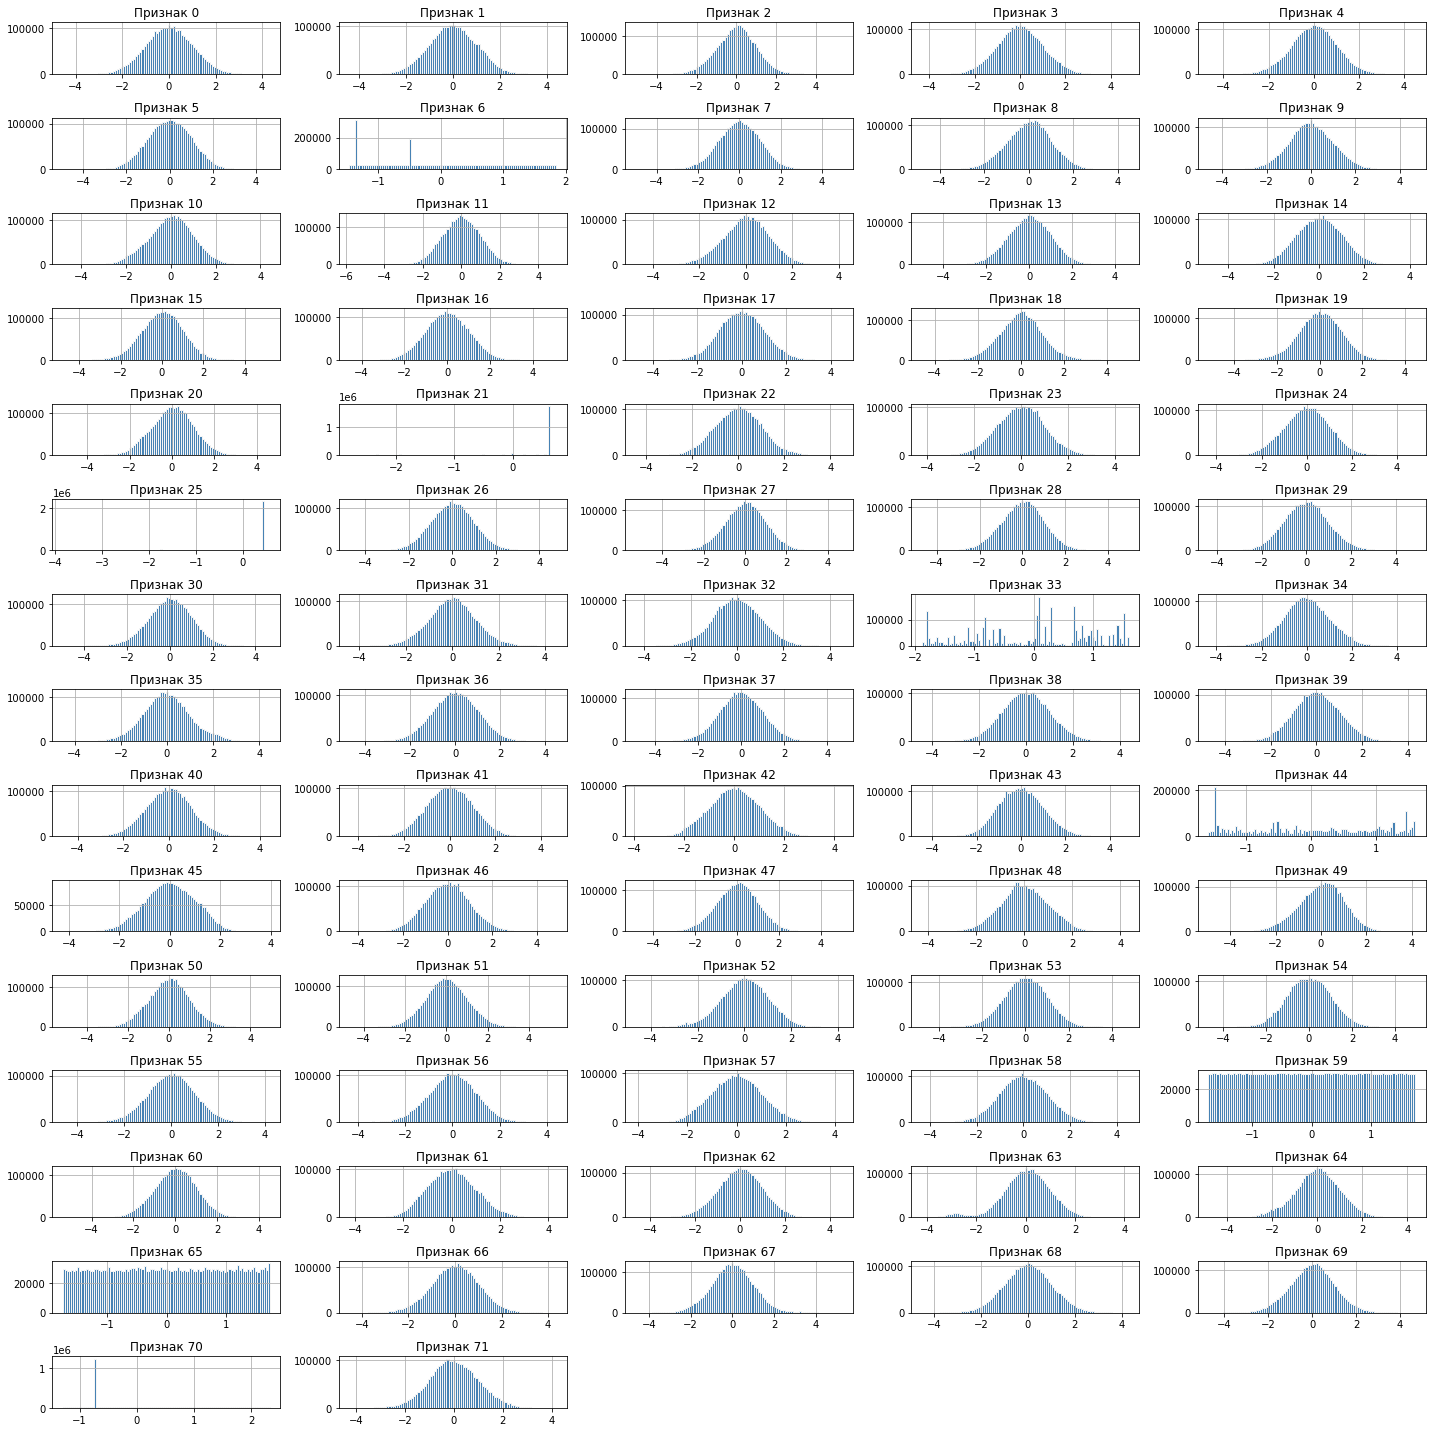

In [16]:
num_columns = base.shape[1] #Get the columns quantity
num_rows = 15 #Rows number in subplot grid
num_cols = 5 #Columns number in subplot grid
fig, axis = plt.subplots(num_rows, num_cols, figsize =(20, 20))

for i, ax in enumerate(axis.flat):
    if i < num_columns:
        base.iloc[:, i].hist(
                bins=100,
                color = 'steelblue',
                edgecolor='whitesmoke',
                linewidth = 1,
                ax=ax
                )
        ax.set_title(f'Признак {i}')

    else:
        ax.axis('off')
    
plt.tight_layout()
plt.show()

In [17]:
%%time
dims = base.shape[1]
n_cells = 500

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

target_train = train["Target"]
features_train = train.drop("Target", axis=1)


# Примение стандартизации к числовым признакам.
numerical_features = features_train.columns
features_train[numerical_features] = scaler.fit_transform(features_train[numerical_features])


idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}

vecs, idx = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), 5)
acc = 0
for i, el in zip(target_train.values.tolist(), idx.tolist()):
    acc += int(i in [base_index[r] for r in el])

print(100 * acc / len(idx))

51.393
CPU times: user 1min 34s, sys: 2.8 s, total: 1min 37s
Wall time: 19.9 s


In [18]:
new_result = {'change description':'Features standardisation',
        'accuracy@5':51.393,
        'time':'20.5 s'
       }
experiment = experiment.append(new_result, ignore_index=True)
experiment

,change description,accuracy@5,time
0,Base line model,5.133,8.47 s
1,Features standardisation,51.393,20.5 s


**Вывод:**

- Стандартизация признаков привела к увеличению качествва метрики в 10 раз. Это показыает важность соблюдения одинакового порядка числовых признаков в моделе обученной на FAISS.

## Удаление признаков с ненормальным распределением значений.

**Проверка гипотезы**

**Гипотеза:**
- Ненормальное распределение в параметрах негативно влияет на обучаемую модель.

In [19]:
drop_list = ['6', '21', '25', '33', '44', '70', '59', '65']
base = base.drop(drop_list, axis=1)
train= train.drop(drop_list, axis=1)

In [20]:
%%time
dims = base.shape[1]
n_cells = 500

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

target_train = train["Target"]
features_train = train.drop("Target", axis=1)


# Примение стандартизации к числовым признакам.
numerical_features = features_train.columns
features_train[numerical_features] = scaler.fit_transform(features_train[numerical_features])


idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}

vecs, idx = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), 5)
acc = 0
for i, el in zip(target_train.values.tolist(), idx.tolist()):
    acc += int(i in [base_index[r] for r in el])

print(100 * acc / len(idx))

60.564
CPU times: user 1min 16s, sys: 2.18 s, total: 1min 18s
Wall time: 15.2 s


In [21]:
new_result = {'change description':'Deleting Features with Non-Normal Distribution',
        'accuracy@5':60.564,
        'time':'15.7 s'
       }
experiment = experiment.append(new_result, ignore_index=True)
experiment

,change description,accuracy@5,time
0,Base line model,5.133,8.47 s
1,Features standardisation,51.393,20.5 s
2,Deleting Features with Non-Normal Distribution,60.564,15.7 s


## Анализ на мультиколлинеарность.

**Анализ на мультиколлинеарность.**

Для анализа используется библиотека Phik. Анализ производится на случайной вывборке из 100.000 значений. 

In [22]:
%%time
# Анализ признаков base.
base_sample = base.sample(n=100000)
#Матрица корреляции / Correlation matrix
phik_base = base_sample.phik_matrix()
phik_base.head()

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27', '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '66', '67', '68', '69', '71']
CPU times: user 1min 19s, sys: 3.35 s, total: 1min 23s
Wall time: 1min 29s


,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
0,1.000000,0.070651,0.081535,0.082998,0.120998,0.072620,0.074632,0.093245,0.061001,0.116303,...,0.056706,0.074411,0.064133,0.159501,0.087236,0.121592,0.081252,0.078406,0.064050,0.202808
1,0.070651,1.000000,0.076328,0.113324,0.077931,0.094901,0.099988,0.112086,0.085693,0.120460,...,0.093992,0.183634,0.085815,0.288533,0.097910,0.164073,0.111035,0.073310,0.079945,0.096341
2,0.081535,0.076328,1.000000,0.043316,0.088807,0.087867,0.108388,0.102641,0.060453,0.101260,...,0.099725,0.091321,0.078750,0.168629,0.121754,0.106948,0.114116,0.111696,0.136953,0.138401
3,0.082998,0.113324,0.043316,1.000000,0.076149,0.064474,0.066663,0.086959,0.067863,0.077236,...,0.051124,0.074973,0.094186,0.120028,0.071358,0.082161,0.071593,0.049966,0.061614,0.089593
4,0.120998,0.077931,0.088807,0.076149,1.000000,0.060967,0.063572,0.052737,0.087670,0.133435,...,0.063249,0.096864,0.071702,0.163369,0.098187,0.124109,0.092242,0.076904,0.068803,0.239599


In [23]:
# Счетчик количества мультиколлинеарных признаков. 
# Признак мультиколлинеарен, если коэффициент корреляии с каждым другим признаком болше  0.98 и
# Если пар корреляции больше чем 1. (Т.к. каждый признак коллениарен сам себе по матрице корреляий.)
count = 0
mlt_col = []
for i in phik_base.columns:
    phik_1 = phik_base.loc[phik_base[i] >= 0.98, i].count()
    
    if phik_1 > 1:
        count += 1
        mlt_col.append(i)
        print(f'Параметр {i} коррелирует с другими параметрами.')
        
if count == 0:
    print('Мультиколлинеарные признаки отсутствуют.')
else:
    print(f'Количесто мультиколлинеарных признаков: {count}')
    

Мультиколлинеарные признаки отсутствуют.


**Вывод:**

- Мультиколлинеарные признаки отсуствуют. 
- Все параметры датафрейма коррелируют с целевым признаком.

# Подбор гиперпараметров к модели FAISS

## Подбор количества кластеров и ближайших соседей.

**Введение переменных:**

1) n_cells - количество кластеров.

2) nprobe - количество ближайших соседей.

Подбор гиперпараметров ниже осуществляется методом перебора. Ниже представлен перечень вариантов подбора. В коде представлен наилучший из них, выбранный путем определения наилучшей метрики.

In [24]:
%%time
dims = base.shape[1]
n_cells = 100

quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

target_train = train["Target"]
features_train = train.drop("Target", axis=1)


# Примение стандартизации к числовым признакам.
numerical_features = features_train.columns
features_train[numerical_features] = scaler.fit_transform(features_train[numerical_features])


idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}

idx_l2.nprobe = 10
vecs, idx = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), 5)
acc = 0
for i, el in zip(target_train.values.tolist(), idx.tolist()):
    acc += int(i in [base_index[r] for r in el])

print(100 * acc / len(idx))

70.397
CPU times: user 48min 23s, sys: 6.04 s, total: 48min 29s
Wall time: 6min 22s


История перебора гиперпараметров.
- n_cells = 500, Metric = 51.393, Time = 20.2
- n_cells = 100, Metric = 54.449, Time = 54.3
- n_cells = 100, nprobe = 5, Metric = 63.452, Time = 4min 24s
- n_cells = 100, nprobe = 5, Metric = 69.452, Time = 5min 12s
- n_cells = 100, nprobe = 10, Metric = 70.397, Time = 6min 34s

In [25]:
new_result = {'change description':'Hyperparameter Research',
        'accuracy@5':70.397,
        'time':'6min 34s'
       }
experiment = experiment.append(new_result, ignore_index=True)
experiment

,change description,accuracy@5,time
0,Base line model,5.133,8.47 s
1,Features standardisation,51.393,20.5 s
2,Deleting Features with Non-Normal Distribution,60.564,15.7 s
3,Hyperparameter Research,70.397,6min 34s


## IndexFlatIP

**Нужно описать что это за индекс и какой его смысл.**

In [26]:
%%time
dims = base.shape[1]
n_cells = 100

quantizer = faiss.IndexFlatIP(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

target_train = train["Target"]
features_train = train.drop("Target", axis=1)


# Примение стандартизации к числовым признакам.
numerical_features = features_train.columns
features_train[numerical_features] = scaler.fit_transform(features_train[numerical_features])


idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}

idx_l2.nprobe = 10
vecs, idx = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), 5)
acc = 0
for i, el in zip(target_train.values.tolist(), idx.tolist()):
    acc += int(i in [base_index[r] for r in el])

print(100 * acc / len(idx))

70.412
CPU times: user 40min 35s, sys: 6.19 s, total: 40min 42s
Wall time: 5min 29s


In [27]:
new_result = {'change description':'IndexFlatIP',
        'accuracy@5':70.412,
        'time':'5min 23s'
       }
experiment = experiment.append(new_result, ignore_index=True)
experiment

,change description,accuracy@5,time
0,Base line model,5.133,8.47 s
1,Features standardisation,51.393,20.5 s
2,Deleting Features with Non-Normal Distribution,60.564,15.7 s
3,Hyperparameter Research,70.397,6min 34s
4,IndexFlatIP,70.412,5min 23s


Метод дает незначительный прирост к метрике качества и ускоряет модель на 15%.

# Определение товара в валидационной выборке.

## Предобработка данных.

### Стандартизация признаков.

In [28]:
validation.head(2)

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.07936
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.00932


In [29]:
# Вычленение словаря с индексами в выввборке validation.
validation_index = {k: v for k, v in enumerate(validation['Id'].to_list())}

In [30]:
#Удаление столбца с кодом товавра.
validation = validation.drop('Id', axis = 1)

In [31]:
# Замена 'df' на  DataFrame и определение списка числовых признаков.
numerical_features = validation.columns

# Примение стандартизации к числовым признакам.
validation[numerical_features] = scaler.fit_transform(validation[numerical_features])

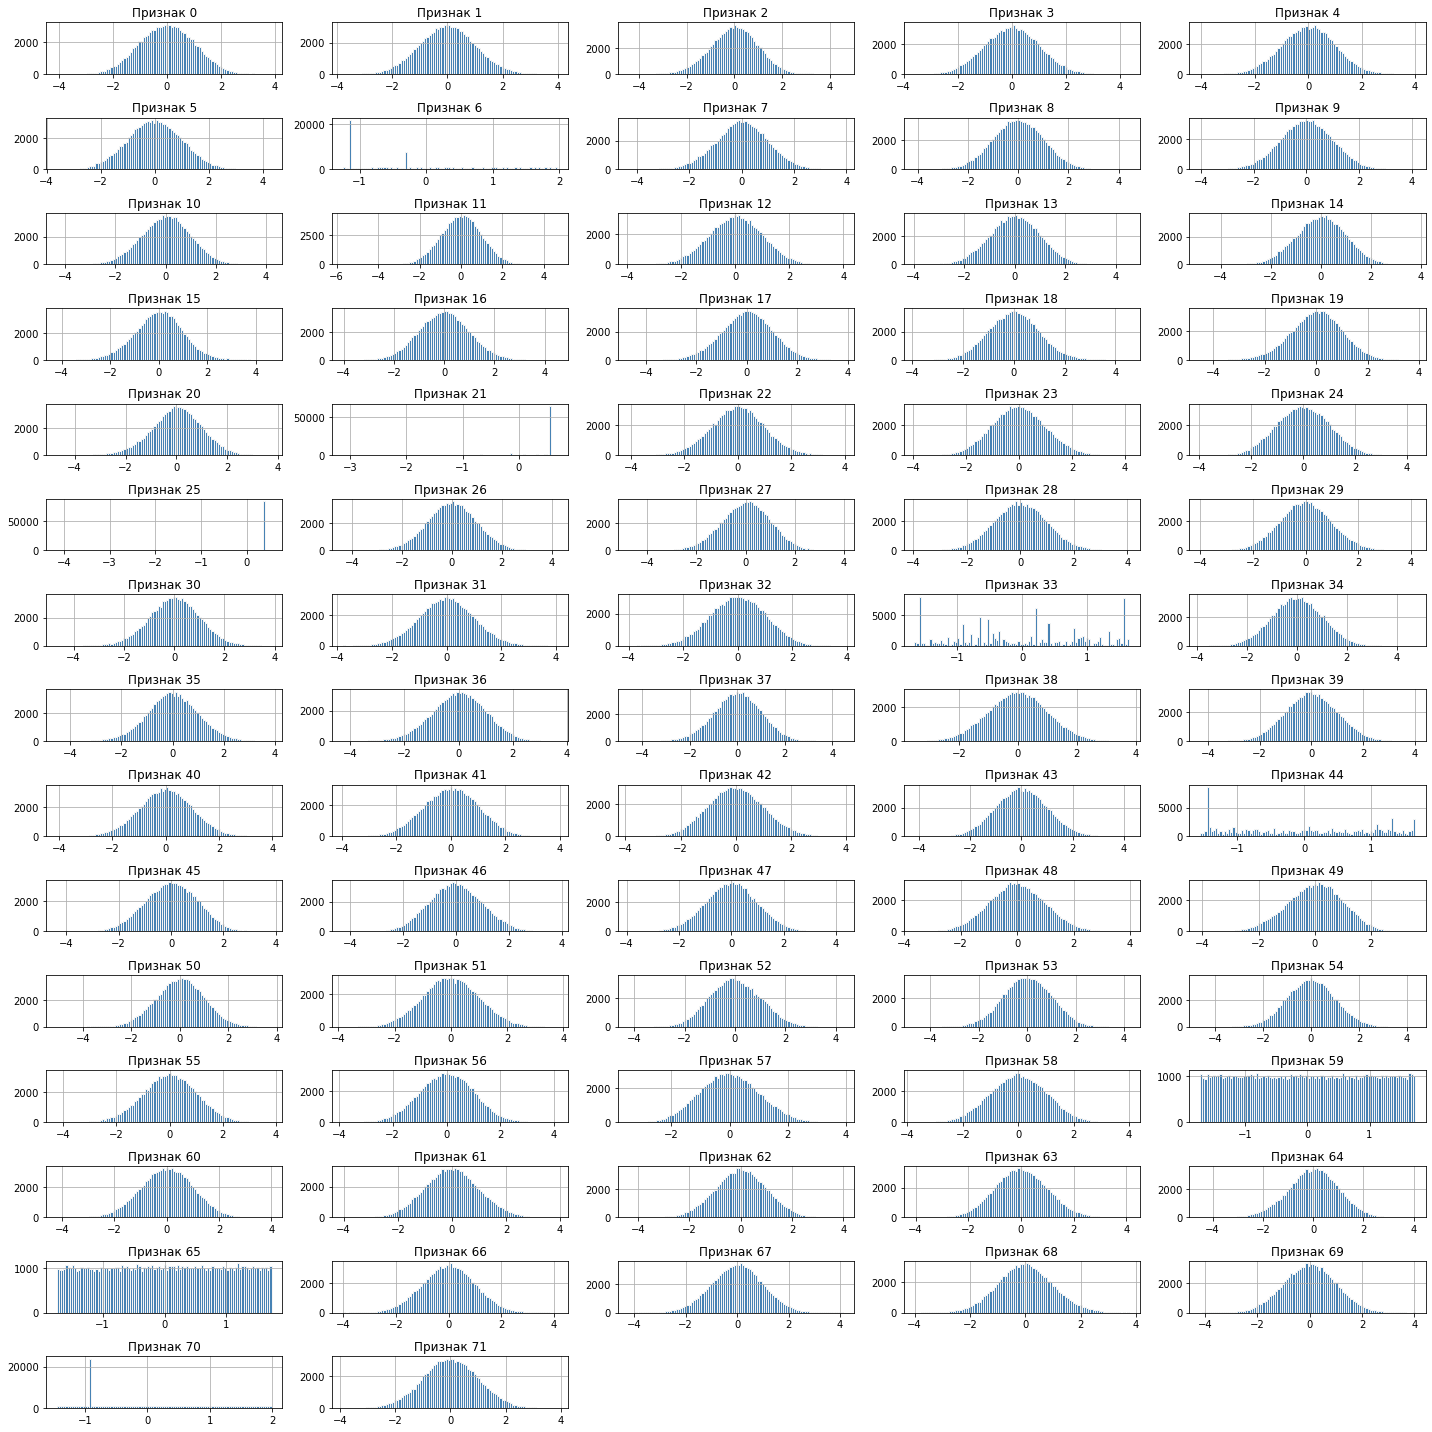

In [32]:
num_columns = validation.shape[1] #Get the columns quantity
num_rows = 15 #Rows number in subplot grid
num_cols = 5 #Columns number in subplot grid
fig, axis = plt.subplots(num_rows, num_cols, figsize =(20, 20))

for i, ax in enumerate(axis.flat):
    if i < num_columns:
        validation.iloc[:, i].hist(
                bins=100,
                color = 'steelblue',
                edgecolor='whitesmoke',
                linewidth = 1,
                ax=ax
                )
        ax.set_title(f'Признак {i}')

    else:
        ax.axis('off')
    
plt.tight_layout()
plt.show()

### Удаление признаков с ненормальным распределением.

In [33]:
drop_list = ['6', '21', '25', '33', '44', '70', '59', '65']
validation = validation.drop(drop_list, axis=1)

## Определение товара с помощью FAISS. 

Определение кандидатов с использованием параметров, подобранных на base.

In [34]:
%%time
dims = base.shape[1]
n_cells = 100

quantizer = faiss.IndexFlatIP(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

CPU times: user 1.37 ms, sys: 126 ms, total: 127 ms
Wall time: 126 ms


In [35]:
%%time
idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))

CPU times: user 5.09 s, sys: 1.24 s, total: 6.33 s
Wall time: 3.37 s


In [36]:
%%time
idx_l2.nprobe = 10
vecs_valid, idx_valid = idx_l2.search(np.ascontiguousarray(validation.values).astype('float32'), 5)
acc = 0

CPU times: user 38min 57s, sys: 4.36 s, total: 39min 1s
Wall time: 5min 17s


In [37]:
%%time
for i, el in zip(validation_answer['Expected'].tolist(), idx_valid.tolist()):
    acc += int(i in [base_index[r] for r in el])

print(100 * acc / len(idx_valid))

70.38
CPU times: user 780 ms, sys: 35.2 ms, total: 815 ms
Wall time: 730 ms


In [38]:
#Внесение результатов исследования в сводную таблицу.
new_result = {'change description':'FAISS with validation',
        'accuracy@5':70.38,
        'time':'5min 16s'
       }
experiment = experiment.append(new_result, ignore_index=True)
experiment

,change description,accuracy@5,time
0,Base line model,5.133,8.47 s
1,Features standardisation,51.393,20.5 s
2,Deleting Features with Non-Normal Distribution,60.564,15.7 s
3,Hyperparameter Research,70.397,6min 34s
4,IndexFlatIP,70.412,5min 23s
5,FAISS with validation,70.380,5min 16s


**Вывод:**

Метрика на авлидационной выборке оказалась практически идентичной метрике на base. Время обучения модели также сопоставимо. Это говорит о том, что омодель работает как и ожидается.

# Ранжирование модели.

По результатам работы FAISS получили для каждого значения из столбца target_train 5 кандидатов из base c индексами idx. Если названия продуктов хотя бы в 1 случае из 5 сопадало и в base и в train тогда считалось, что FAISS точно определил товар.

Создадим 5 датасетов. Каждый будет иметь по одной паре train - base. (На 1 значение из train приходится 5 значений из base)

## Стандартизация значений в train.

In [39]:
# Определение числовых признаков.
numerical_features = train.columns
numerical_features = numerical_features.drop('Target')
numerical_features

Index(['0', '1', '2', '3', '4', '5', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '22', '23', '24', '26', '27',
       '28', '29', '30', '31', '32', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '57', '58', '60', '61', '62', '63', '64', '66', '67',
       '68', '69', '71'],
      dtype='object')

In [40]:
# Примение стандартизации к числовым признакам.
train[numerical_features] = scaler.fit_transform(train[numerical_features])
train.head(2)

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,-2.153763,-1.474397,1.275871,...,-0.182183,-0.791579,1.309634,-0.087262,-1.031430,0.206023,-0.173143,0.906949,0.547062,675816-base
1-query,-0.094858,-0.173152,0.296912,-1.523962,0.189363,-0.370205,-1.510417,0.284657,0.218924,-0.875735,...,-0.716320,1.314829,-1.270984,0.012808,0.202021,0.037262,0.266272,0.713549,-0.067236,366656-base


**Признаки стандартизировваны.**

## CatBoost

### Разработка признаков для обучающей выборки CatBoost на train и base.

![](https://raw.githubusercontent.com/htoniy/Data-Science_Classic-ML/main/01_Product%20matching/images/Features%20generation.png)

В качестве признаков склеиваются датасеты base и train следующим образом:

1) Для каждого элемента train нанаходится 50 кандидатов из base.

2) К каждому элементу train поочередно присоединяется 1 из 50 кандидатов.

3) Таким сращиваением данных из 1 элемента train и 50 элементов из base получается 50 элементов в обучающей выборке. 


#### Подбор кандидатов.

In [41]:
%%time
dims = base.shape[1]
n_cells = 100

quantizer = faiss.IndexFlatIP(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

target_train = train["Target"]
features_train = train.drop("Target", axis=1)


# Примение стандартизации к числовым признакам.
numerical_features = features_train.columns
features_train[numerical_features] = scaler.fit_transform(features_train[numerical_features])


idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))
base_index = {k: v for k, v in enumerate(base.index.to_list())}

idx_l2.nprobe = 10
vecs_50, idx_50 = idx_l2.search(np.ascontiguousarray(features_train.values).astype('float32'), 50) 

#В последней строке изменено количество кандидатов.

CPU times: user 38min 47s, sys: 6.74 s, total: 38min 54s
Wall time: 5min 21s


#### Цикл добавления всех пятидесяти кандидатов для каждого значения в train.

In [42]:
# Создание формы датасета с соединенными данными из base & train.
columns = ['0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '7_x', '8_x', '9_x', 
            '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', 
            '20_x', '22_x', '23_x', '24_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', 
            '32_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', 
            '42_x', '43_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', 
            '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '60_x', '61_x', '62_x', '63_x', 
            '64_x', '66_x', '67_x', '68_x', '69_x', '71_x', 'Target', 'candidate_1', 
            'indx_base', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '7_y', '8_y', '9_y', '10_y', 
            '11_y', '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', 
            '22_y', '23_y', '24_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y', '32_y', '34_y', 
            '35_y', '36_y', '37_y', '38_y', '39_y', '40_y', '41_y', '42_y', '43_y', '45_y', '46_y', 
            '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y', '56_y', '57_y', 
            '58_y', '60_y', '61_y', '62_y', '63_y', '64_y', '66_y', '67_y', '68_y', '69_y', '71_y']

# DataFrame без строк, только с заданными названиями столбцов/
cbc_data = pd.DataFrame(columns=columns)

# В заданный датасет будем добавлять результат объединения таблиц из цикла.

In [43]:
%%time
#ДатаФрейм base с вынесенными индексами.
base_indx = base.reset_index()
base_indx = base_indx.rename(columns={'Id': 'indx_base'})
base_indx

#Создайте столбец 'candidate_i' для каждого кандидата
for i in range(50):
    train_i = train.copy()
    # Определение столбца 'candidate_i' для каждого кандидата
    train_i['candidate_i'] = idx_50[:, i]

    # Присоединие информации из 'base' к 'train_i' на основе 'candidate_i'
    train_i['indx_base'] = train_i['candidate_i'].map(base_index)

    # Присоединие данных из 'base_indx' к 'train_i' на основе 'indx_base'
    train_i = train_i.merge(base_indx, on='indx_base', how='left')

    # Добавление результатов в cbc_data
    cbc_data = pd.concat([cbc_data, train_i], axis=0, ignore_index=True)

#cbc_data теперь содержит результаты для всех кандидатов
# Для 20 кандидатов - 3 мин 36 сек.
# Для 30 кандидатов - 12min 57s

CPU times: user 8min 51s, sys: 24min 17s, total: 33min 8s
Wall time: 46min 46s


**Вывод:**

Для оптимальной кода окончательно примем количество кандидатовв равное 50.

In [44]:
cbc_data.head(4)

,0_x,1_x,2_x,3_x,4_x,5_x,7_x,8_x,9_x,10_x,...,61_y,62_y,63_y,64_y,66_y,67_y,68_y,69_y,71_y,candidate_i
0,1.218659,2.079877,0.039629,-1.850675,1.587961,-0.486308,0.258787,-2.153763,-1.474397,1.275871,...,0.216622,-0.33215,1.723392,-0.369458,-1.100241,0.280916,-0.492041,0.532096,0.090279,336969.0
1,-0.094858,-0.173152,0.296912,-1.523962,0.189363,-0.370205,-1.510417,0.284657,0.218924,-0.875735,...,-0.834428,1.279994,-1.413195,-0.103806,-0.250326,-0.977445,0.397733,0.307689,-0.121225,15185.0
2,1.369923,-0.771418,-1.852466,-1.677699,1.642697,0.777931,-0.783196,0.416398,1.316968,1.317597,...,-1.530799,0.915102,2.123639,-0.522077,-0.836205,-0.113768,1.558856,0.741192,0.353818,1162532.0
3,1.453981,0.286998,-1.834136,1.228656,-0.358857,-1.256206,0.878306,0.144055,1.795195,-0.128546,...,0.371812,0.755426,0.274636,0.451152,-2.070518,1.333446,-0.330587,0.154933,1.223246,1179186.0


**Генерация целевого признака.**

Если наименоавние товара, проставленное экспертом соответствует индексу товара, то товар из рекомендации соответствует фактическому товару.

Ниже представлена функция, которая определит релевантность товаров.

In [45]:
# Функция для определения совпадения товаров.
def is_correct(row):
    if row['Target'] == row['indx_base']:
        return 1
    else:
        return 0

In [46]:
cbc_data['match'] = cbc_data.apply(is_correct, axis =1)
cbc_data['match'].value_counts()

0    4922386
1      77614
Name: match, dtype: int64

**Проверка правильности кода.**

Количество товаров, которые соотносятся с размеченными данными из train, примерно равно Accuracy. Это говорит об отсутствии ошибок в коде.

#### Подготовка 30 кандидатов для валидационной выбокри.

In [47]:
%%time
dims = base.shape[1]
n_cells = 100

quantizer = faiss.IndexFlatIP(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))

idx_l2.nprobe = 10
vecs_valid, idx_valid = idx_l2.search(np.ascontiguousarray(validation.values).astype('float32'), 30)
acc = 0

CPU times: user 39min 17s, sys: 11 s, total: 39min 28s
Wall time: 5min 28s


### Разработка признаков для валидационной выборки CatBoost на validation и base.

**Цикл добавления всех пяти кандидатов для каждого значения в validation.**

In [48]:
# Создание формы датасета с соединенными данными из base & train.
columns_valid = ['0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '7_x', '8_x', '9_x', 
            '10_x', '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', 
            '20_x', '22_x', '23_x', '24_x', '26_x', '27_x', '28_x', '29_x', '30_x', '31_x', 
            '32_x', '34_x', '35_x', '36_x', '37_x', '38_x', '39_x', '40_x', '41_x', 
            '42_x', '43_x', '45_x', '46_x', '47_x', '48_x', '49_x', '50_x', '51_x', '52_x', 
            '53_x', '54_x', '55_x', '56_x', '57_x', '58_x', '60_x', '61_x', '62_x', '63_x', 
            '64_x', '66_x', '67_x', '68_x', '69_x', '71_x', 'Target', 'candidate_1', 
            'indx_base', '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '7_y', '8_y', '9_y', '10_y', 
            '11_y', '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', 
            '22_y', '23_y', '24_y', '26_y', '27_y', '28_y', '29_y', '30_y', '31_y', '32_y', '34_y', 
            '35_y', '36_y', '37_y', '38_y', '39_y', '40_y', '41_y', '42_y', '43_y', '45_y', '46_y', 
            '47_y', '48_y', '49_y', '50_y', '51_y', '52_y', '53_y', '54_y', '55_y', '56_y', '57_y', 
            '58_y', '60_y', '61_y', '62_y', '63_y', '64_y', '66_y', '67_y', '68_y', '69_y', '71_y']

# DataFrame без строк, только с заданными названиями столбцов/
cbc_valid = pd.DataFrame(columns=columns)

# В заданный датасет будем добавлять результат объединения таблиц из цикла.

In [49]:
valid_i = validation

# ДатаФрейм base с вынесенными индексами.
base_indx = base.reset_index()
base_indx = base_indx.rename(columns={'Id': 'indx_base'})
base_indx

for i in range(30):
    
    # Выбор i-го кандидата из колонки idx
    i_column = idx_valid[:, i]

    # К фрейму данных train добавляется колонка с сопоставлением индексов первого кандидата.
    valid_i['candidate_i'] = i_column

    # Преобразоание столбца 'candidate_i' в массив numpy для более быстрой обработки данных.
    candidate_i_values = valid_i['candidate_i'].values

    # Создание массива для результатов.
    result = np.empty(len(valid_i), dtype=object)

    # Определение соответствующего значения в словаре base_index для каждого значения столбца 'candidate_i'.
    for j in range(len(valid_i)):
        result[j] = base_index.get(candidate_i_values[j], None)

    # Добавление индекса base для каждого элемента train.
    valid_i['indx_base'] = result
    
    # Присоединяем таблицы valid & base по столбцу 'indx_base' с использованием метода merge с 'left'
    result = valid_i.merge(base_indx, on='indx_base', how='left')  # 'left' означает объединение по левой таблице

    # Присоединение result к общей таблице данных. Методом concat() для добавления строк result к cbc_data.
    cbc_valid = pd.concat([cbc_valid, result], axis=0, ignore_index=True)

In [50]:
cbc_valid.head(2)

,0_x,1_x,2_x,3_x,4_x,5_x,7_x,8_x,9_x,10_x,...,61_y,62_y,63_y,64_y,66_y,67_y,68_y,69_y,71_y,candidate_i
0,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,-1.567549,-0.781536,0.224272,...,-1.578071,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162421,-1.245106,1954150.0
1,1.223699,1.033006,0.014664,0.570965,0.058948,-0.60483,0.63782,0.621098,-1.12143,-0.300755,...,-1.133644,-1.306876,-0.014165,0.331693,1.504163,-1.630335,0.441753,0.091108,-0.51012,1902634.0


### Определение признаков для загрузки в CatBoost.

**Train.**

In [52]:
# X - features, y - target
y_train = cbc_data['match'].values
X_train_indx = cbc_data['candidate_i']
X_train = cbc_data.drop(['Target', 'candidate_i', 'indx_base', 'match', 'candidate_1'], axis = 1)


**Validation.**

In [53]:
# X - features, y - target
y_valid = cbc_data['match']
X_valid_indx = cbc_valid['candidate_i']
X_valid = cbc_valid.drop(['Target', 'candidate_i', 'indx_base', 'candidate_1'], axis = 1)

### Обучение модели CatBosst Classifier

In [54]:
%%time
# cbc_model = CatBoostClassifier()
cbc_model = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    random_seed=63,
    #loss_function='Logloss',
    #eval_metric = 'AUC',
    #boosting_type='Ordered'
    #    loss_function='MultiClass',
    #     eval_metric = 'MultiClass',
    #    boosting_type='Ordered'

)

# Fit model
cbc_model.fit(X_train, y_train)

0:	learn: 0.5133725	total: 1.36s	remaining: 22m 37s
1:	learn: 0.3867467	total: 3.02s	remaining: 25m 8s
2:	learn: 0.2984537	total: 4.25s	remaining: 23m 31s
3:	learn: 0.2369286	total: 5.67s	remaining: 23m 31s
4:	learn: 0.1938979	total: 6.93s	remaining: 22m 59s
5:	learn: 0.1635525	total: 8.05s	remaining: 22m 13s
6:	learn: 0.1409107	total: 9.32s	remaining: 22m 2s
7:	learn: 0.1246008	total: 10.5s	remaining: 21m 45s
8:	learn: 0.1121703	total: 12.1s	remaining: 22m 7s
9:	learn: 0.1031163	total: 13.4s	remaining: 22m 3s
10:	learn: 0.0959900	total: 14.9s	remaining: 22m 16s
11:	learn: 0.0904815	total: 16.6s	remaining: 22m 46s
12:	learn: 0.0864164	total: 18.2s	remaining: 22m 58s
13:	learn: 0.0834953	total: 19.5s	remaining: 22m 55s
14:	learn: 0.0811209	total: 21.1s	remaining: 23m 8s
15:	learn: 0.0791847	total: 22.4s	remaining: 22m 55s
16:	learn: 0.0776695	total: 23.7s	remaining: 22m 50s
17:	learn: 0.0763870	total: 24.8s	remaining: 22m 34s
18:	learn: 0.0752425	total: 26s	remaining: 22m 23s
19:	learn:

153:	learn: 0.0486619	total: 3m 11s	remaining: 17m 31s
154:	learn: 0.0485771	total: 3m 12s	remaining: 17m 31s
155:	learn: 0.0485101	total: 3m 14s	remaining: 17m 30s
156:	learn: 0.0484608	total: 3m 15s	remaining: 17m 29s
157:	learn: 0.0484007	total: 3m 16s	remaining: 17m 27s
158:	learn: 0.0483254	total: 3m 17s	remaining: 17m 27s
159:	learn: 0.0482804	total: 3m 19s	remaining: 17m 26s
160:	learn: 0.0482432	total: 3m 20s	remaining: 17m 24s
161:	learn: 0.0481885	total: 3m 21s	remaining: 17m 21s
162:	learn: 0.0481250	total: 3m 22s	remaining: 17m 21s
163:	learn: 0.0480663	total: 3m 24s	remaining: 17m 20s
164:	learn: 0.0480165	total: 3m 25s	remaining: 17m 19s
165:	learn: 0.0479753	total: 3m 26s	remaining: 17m 18s
166:	learn: 0.0479195	total: 3m 27s	remaining: 17m 17s
167:	learn: 0.0478494	total: 3m 29s	remaining: 17m 18s
168:	learn: 0.0478014	total: 3m 30s	remaining: 17m 15s
169:	learn: 0.0477414	total: 3m 31s	remaining: 17m 14s
170:	learn: 0.0477011	total: 3m 32s	remaining: 17m 11s
171:	learn

304:	learn: 0.0433430	total: 6m 5s	remaining: 13m 52s
305:	learn: 0.0433249	total: 6m 6s	remaining: 13m 50s
306:	learn: 0.0432985	total: 6m 7s	remaining: 13m 50s
307:	learn: 0.0432757	total: 6m 8s	remaining: 13m 48s
308:	learn: 0.0432542	total: 6m 10s	remaining: 13m 47s
309:	learn: 0.0432257	total: 6m 11s	remaining: 13m 47s
310:	learn: 0.0432014	total: 6m 13s	remaining: 13m 47s
311:	learn: 0.0431793	total: 6m 14s	remaining: 13m 46s
312:	learn: 0.0431581	total: 6m 15s	remaining: 13m 44s
313:	learn: 0.0431408	total: 6m 16s	remaining: 13m 42s
314:	learn: 0.0431299	total: 6m 16s	remaining: 13m 39s
315:	learn: 0.0431079	total: 6m 17s	remaining: 13m 37s
316:	learn: 0.0430947	total: 6m 18s	remaining: 13m 35s
317:	learn: 0.0430792	total: 6m 19s	remaining: 13m 34s
318:	learn: 0.0430631	total: 6m 20s	remaining: 13m 32s
319:	learn: 0.0430379	total: 6m 21s	remaining: 13m 31s
320:	learn: 0.0430261	total: 6m 22s	remaining: 13m 29s
321:	learn: 0.0430183	total: 6m 23s	remaining: 13m 27s
322:	learn: 0.

455:	learn: 0.0411696	total: 8m 49s	remaining: 10m 31s
456:	learn: 0.0411624	total: 8m 50s	remaining: 10m 30s
457:	learn: 0.0411493	total: 8m 51s	remaining: 10m 28s
458:	learn: 0.0411395	total: 8m 52s	remaining: 10m 27s
459:	learn: 0.0411217	total: 8m 53s	remaining: 10m 26s
460:	learn: 0.0411138	total: 8m 55s	remaining: 10m 25s
461:	learn: 0.0411049	total: 8m 56s	remaining: 10m 24s
462:	learn: 0.0410889	total: 8m 57s	remaining: 10m 23s
463:	learn: 0.0410791	total: 8m 58s	remaining: 10m 22s
464:	learn: 0.0410637	total: 9m	remaining: 10m 21s
465:	learn: 0.0410479	total: 9m 1s	remaining: 10m 20s
466:	learn: 0.0410412	total: 9m 2s	remaining: 10m 19s
467:	learn: 0.0410254	total: 9m 3s	remaining: 10m 18s
468:	learn: 0.0410083	total: 9m 5s	remaining: 10m 17s
469:	learn: 0.0409950	total: 9m 6s	remaining: 10m 15s
470:	learn: 0.0409832	total: 9m 7s	remaining: 10m 14s
471:	learn: 0.0409761	total: 9m 8s	remaining: 10m 13s
472:	learn: 0.0409686	total: 9m 9s	remaining: 10m 12s
473:	learn: 0.0409636	

606:	learn: 0.0397806	total: 11m 44s	remaining: 7m 36s
607:	learn: 0.0397714	total: 11m 45s	remaining: 7m 35s
608:	learn: 0.0397675	total: 11m 46s	remaining: 7m 33s
609:	learn: 0.0397595	total: 11m 47s	remaining: 7m 32s
610:	learn: 0.0397520	total: 11m 48s	remaining: 7m 31s
611:	learn: 0.0397464	total: 11m 49s	remaining: 7m 30s
612:	learn: 0.0397419	total: 11m 50s	remaining: 7m 28s
613:	learn: 0.0397399	total: 11m 51s	remaining: 7m 27s
614:	learn: 0.0397325	total: 11m 52s	remaining: 7m 26s
615:	learn: 0.0397222	total: 11m 53s	remaining: 7m 24s
616:	learn: 0.0397140	total: 11m 54s	remaining: 7m 23s
617:	learn: 0.0397111	total: 11m 55s	remaining: 7m 22s
618:	learn: 0.0397021	total: 11m 56s	remaining: 7m 21s
619:	learn: 0.0396916	total: 11m 57s	remaining: 7m 20s
620:	learn: 0.0396805	total: 11m 59s	remaining: 7m 19s
621:	learn: 0.0396691	total: 12m 1s	remaining: 7m 18s
622:	learn: 0.0396609	total: 12m 2s	remaining: 7m 17s
623:	learn: 0.0396576	total: 12m 4s	remaining: 7m 16s
624:	learn: 0

757:	learn: 0.0387449	total: 14m 46s	remaining: 4m 43s
758:	learn: 0.0387370	total: 14m 47s	remaining: 4m 41s
759:	learn: 0.0387321	total: 14m 48s	remaining: 4m 40s
760:	learn: 0.0387242	total: 14m 50s	remaining: 4m 39s
761:	learn: 0.0387166	total: 14m 51s	remaining: 4m 38s
762:	learn: 0.0387116	total: 14m 51s	remaining: 4m 37s
763:	learn: 0.0387045	total: 14m 52s	remaining: 4m 35s
764:	learn: 0.0387010	total: 14m 53s	remaining: 4m 34s
765:	learn: 0.0386954	total: 14m 55s	remaining: 4m 33s
766:	learn: 0.0386854	total: 14m 56s	remaining: 4m 32s
767:	learn: 0.0386826	total: 14m 57s	remaining: 4m 31s
768:	learn: 0.0386788	total: 14m 59s	remaining: 4m 30s
769:	learn: 0.0386702	total: 15m	remaining: 4m 29s
770:	learn: 0.0386595	total: 15m 1s	remaining: 4m 27s
771:	learn: 0.0386490	total: 15m 2s	remaining: 4m 26s
772:	learn: 0.0386428	total: 15m 3s	remaining: 4m 25s
773:	learn: 0.0386317	total: 15m 4s	remaining: 4m 24s
774:	learn: 0.0386213	total: 15m 6s	remaining: 4m 23s
775:	learn: 0.03861

908:	learn: 0.0378667	total: 17m 24s	remaining: 1m 44s
909:	learn: 0.0378639	total: 17m 25s	remaining: 1m 43s
910:	learn: 0.0378609	total: 17m 26s	remaining: 1m 42s
911:	learn: 0.0378601	total: 17m 27s	remaining: 1m 41s
912:	learn: 0.0378562	total: 17m 27s	remaining: 1m 39s
913:	learn: 0.0378483	total: 17m 28s	remaining: 1m 38s
914:	learn: 0.0378386	total: 17m 29s	remaining: 1m 37s
915:	learn: 0.0378339	total: 17m 30s	remaining: 1m 36s
916:	learn: 0.0378287	total: 17m 32s	remaining: 1m 35s
917:	learn: 0.0378251	total: 17m 32s	remaining: 1m 34s
918:	learn: 0.0378207	total: 17m 34s	remaining: 1m 32s
919:	learn: 0.0378170	total: 17m 34s	remaining: 1m 31s
920:	learn: 0.0378121	total: 17m 36s	remaining: 1m 30s
921:	learn: 0.0378059	total: 17m 37s	remaining: 1m 29s
922:	learn: 0.0377991	total: 17m 38s	remaining: 1m 28s
923:	learn: 0.0377899	total: 17m 39s	remaining: 1m 27s
924:	learn: 0.0377841	total: 17m 41s	remaining: 1m 26s
925:	learn: 0.0377774	total: 17m 42s	remaining: 1m 24s
926:	learn

### Model prediction.

In [55]:
#Test data predictions
predicted_valid = cbc_model.predict_proba(X_valid)
predicted_valid

array([[8.75616106e-01, 1.24383894e-01],
       [9.93970704e-01, 6.02929594e-03],
       [1.81379910e-01, 8.18620090e-01],
       ...,
       [9.99890123e-01, 1.09876912e-04],
       [9.99922146e-01, 7.78539957e-05],
       [9.96519225e-01, 3.48077451e-03]])

In [56]:
cbc_valid['predicted'] = predicted_valid[:,1]
cbc_valid

,0_x,1_x,2_x,3_x,4_x,5_x,7_x,8_x,9_x,10_x,...,62_y,63_y,64_y,66_y,67_y,68_y,69_y,71_y,candidate_i,predicted
0,1.083497,-0.821465,0.782574,0.985244,-0.01862,-0.280778,1.778363,-1.567549,-0.781536,0.224272,...,-0.061286,0.089266,0.047589,0.533942,1.168393,-0.104937,0.162421,-1.245106,1954150.0,0.124384
1,1.223699,1.033006,0.014664,0.570965,0.058948,-0.60483,0.63782,0.621098,-1.12143,-0.300755,...,-1.306876,-0.014165,0.331693,1.504163,-1.630335,0.441753,0.091108,-0.51012,1902634.0,0.006029
2,0.819606,-2.35036,0.923979,-1.172999,-0.318083,0.382082,0.991059,1.259418,0.660486,-1.902755,...,-1.831183,0.140928,-0.118053,-0.044484,1.128726,1.021673,1.20484,-0.555275,431806.0,0.818620
3,-0.542519,1.705522,1.371528,-0.094687,-0.585072,-2.120127,-0.611346,-1.235272,-0.781675,0.648174,...,0.043575,0.328845,0.5617,1.68162,0.07348,0.865355,1.337721,-0.973723,2171299.0,0.482135
4,0.223815,-1.620729,0.710681,-1.208325,1.127065,1.577431,0.192801,0.895672,-0.368015,1.563724,...,-1.291088,0.315256,0.024802,1.33973,-0.464542,1.822797,-0.534631,-1.620306,1003744.0,0.515980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,1.49859,-0.206887,1.308656,1.463418,-0.661832,0.877567,1.30203,-0.053495,-0.344055,-0.890386,...,0.134207,0.13264,-0.420391,-0.483932,0.821077,-0.674057,-1.040496,0.859821,2012578.0,0.000073
2999996,-0.367925,0.642111,1.47023,1.000243,-1.88663,-0.573458,-1.024515,0.07702,-0.799738,-0.309325,...,-0.012273,1.092299,1.645983,-1.924523,-2.012884,-0.254845,-2.024923,-0.409751,1513651.0,0.009910
2999997,1.011661,1.193495,1.699029,0.546159,0.70303,0.350508,-0.079979,0.779769,0.659179,-0.040546,...,0.628298,-0.450512,-0.403835,1.225888,0.836019,0.205986,-0.27269,0.954626,1293404.0,0.000110
2999998,2.015293,0.807264,0.313365,0.908779,-0.755041,1.289288,-1.531577,0.097493,-1.432078,-0.051448,...,0.110573,-0.795546,0.549392,0.100738,0.592179,-0.296376,0.382644,-0.276002,996650.0,0.000078


**Анализ предсказания модели.**

В столбец predicted добавлены вероятности полного совпадения запроса из validation и товара из base.

Необходимо отметить, что каждая строка из первых 100.000 строк датасета cbc_valid соответствует строкам из validation по индексации. Также индексы строк cbc_valid повторяются 30 раз каждые 100.000 строк.

In [57]:
# Увеличение validation_answer в 30 раз, 
# путем копирования строк для полного соответствия датасета индексации в validation. 

# Создание нового DataFrame. Объединение validation_answer с самим собой четыре разаа.
expanded_validation_answer = pd.concat([validation_answer] * 30, axis=0, ignore_index=True)
expanded_validation_answer.shape

(3000000, 2)

In [58]:
# Добавление в expanded_validation_answer индекса base и вероятностей совпадения индекса base с запросом.
expanded_validation_answer['indx_base'] = cbc_valid['indx_base']
expanded_validation_answer['predict'] = cbc_valid['predicted']
expanded_validation_answer.head(2)

,Id,Expected,indx_base,predict
0,100000-query,2676668-base,2760762-base,0.124384
1,100001-query,91606-base,2666508-base,0.006029


In [59]:
%%time
#Цикл рассчета метрики accuracy@5

acc = 0
for i, index in zip(validation_answer['Id'], validation_answer['Expected']):
    if index in list(expanded_validation_answer[expanded_validation_answer['Id'] == i].sort_values(by = 'predict', ascending = False).head(5)['indx_base']):
        acc += 1
        
print(100 * acc / len(validation_answer))

68.691


метрика на данных только из CatBoost выходит 65.948.

In [62]:
#Внесение результатов исследования в сводную таблицу.
new_result = {'change description':'FAISS with СatBoost Ranking',
        'accuracy@5':68.691,
        'time':'1our 30min'
       }
experiment = experiment.append(new_result, ignore_index=True)
experiment

,change description,accuracy@5,time
0,Base line model,5.133,8.47 s
1,Features standardisation,51.393,20.5 s
2,Deleting Features with Non-Normal Distribution,60.564,15.7 s
3,Hyperparameter Research,70.397,6min 34s
4,IndexFlatIP,70.412,5min 23s
5,FAISS with validation,70.380,5min 16s
6,FAISS with СatBoost Ranking,65.948,5min 16s
7,FAISS with СatBoost Ranking,68.691,1our 30min


После матчинга товаров в FAISS было выявлено, что около 30% товаров не определены. По результатам обучения в  CatBoost для этих позиций произведем замену предсказанных данных. С данных из FAISS на данные из CatBoost.

# Вывод.

В рамках проекта была разработана рекомендательная система, позволяющая определять товар из ассортимента магазина по набору характеристик.

В работе определены ключеввые точки, которые влияют на качество работы модели.

- Стандартизация признаков. Т.к. FAISS  работает с евклидовыми расстояниями - порядок переменных важен. После стандартизациции метрика на train составила 51.393.
- Определены признаки, не имеющие нормального распределения данных. Эмперически выяалено, что удаление таких признаков из данных, повышает метрику до 60.564.
- Подбор гиперпараметров FAISS. Поднял метрику до 70.412
- На валидационной выборке метрика качества вышла раавной 70.38.

В проекте также проведена работа по ранжированию модели и по анализу признаков на мультиколлинеарность. Однако исследоввания в данных направлениях не позволили получить прирост к метрике качества. 
 
**Применены следующие инструменты:**
- FAISS;
- CatBoost;
- Pandas;
- Numpy.

**Качествво модели.**

Качество модели проекта определяется метрикой accuracy@5.

Accuracy@5 = 70.38 %


# Проблемные вопросы.

1) Выполнение кода в тетрадке занимает очень много времени от 2 до 3 часов. не получается оптимизировать время работы алгоритма. Прошу дать рекомендацию о том, как можно это улучшить.

2) Не удалось улучшить метрику accuracy@5 с помощью ранжирования модели. При ранжировании модели метрика accuracy@5 получается ниже, чем просто при работе рекомендательной системы построенной на FAISS. Прошу объяснить почему так выходит.

3) Особенно долго работае блок кода, рассчитывающий финальную метрику в ячейке 59. Прошу подсказать как оптимизироать время выполнения кода.